# Libraries

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.14 s (started: 2022-01-14 08:19:19 +00:00)


In [32]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.25 s (started: 2022-01-14 08:19:21 +00:00)


In [33]:
import os
import glob
from tqdm import tqdm
import re 
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

import time
import datetime


from PIL import Image
from PIL import ImageFile
from skimage import io
from skimage.transform import rescale
from skimage.transform import resize


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification

time: 11.3 ms (started: 2022-01-14 08:19:24 +00:00)


# Variables

## Paths

In [34]:
root_dir ='/content/drive/MyDrive/Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
images_dir = raw_data_dir + 'IMAGES/'
json_dir = raw_data_dir + 'JSON/'
ML_dir = root_dir + 'DOE_Resolution_images/' + 'export/'

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
export_dir = ML_dir + timestamp + '/'
os.makedirs(export_dir)

time: 9.03 ms (started: 2022-01-14 08:19:24 +00:00)


## Other

In [35]:
# seed
random_seed = 42

# min images per family
min_img_per_fam = 5000

# build csv
loop_over_images = False

debug = False
# random row picking dans le df initial(avec chemin des fichiers) if true
len_max = 100 if debug else None



time: 6.12 ms (started: 2022-01-14 08:19:24 +00:00)


# Load & filter dataset EDA

In [36]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/RAW DATA"
if os.path.exists(main_path)== False :
  !unzip '/content/drive/MyDrive/Projet datascientest/RAW DATA.zip' -d "/content"

time: 4.09 ms (started: 2022-01-14 08:19:24 +00:00)


In [37]:
df_raw =  pd.read_csv(root_dir + 'image_and_json_data.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time: 2.34 s (started: 2022-01-14 08:19:24 +00:00)


In [38]:
#select only 320,240 images with family info
df_raw = df_raw[df_raw['resolution']=='(320, 240)'] 

time: 113 ms (started: 2022-01-14 08:19:27 +00:00)


In [39]:
# drop na 
df_raw = df_raw[df_raw['gbif_info.family'].notna()]
# df.isna().sum()

time: 85.5 ms (started: 2022-01-14 08:19:27 +00:00)


In [40]:
# keep conf level over 90 
df_raw = df_raw.loc[df_raw['gbif_info.confidence']>90]

time: 39 ms (started: 2022-01-14 08:19:27 +00:00)


In [41]:
# keep only most common class
top_class = df_raw['gbif_info.class'].value_counts().index[0]
df_raw = df_raw[df_raw['gbif_info.class'] == top_class]

time: 75.5 ms (started: 2022-01-14 08:19:27 +00:00)


In [42]:
#  add a family count for later masking
df_ = pd.DataFrame(df_raw['gbif_info.family'].value_counts().reset_index())
df_.columns = ['gbif_info.family', 'family_count']
df_raw = pd.merge(df_raw, df_, on='gbif_info.family')

time: 608 ms (started: 2022-01-14 08:19:27 +00:00)


In [43]:
# SPECIFIC DRIVE lo laod image from content 
df_raw['file_path'] =df_raw['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                               '/content'))
df_raw['file_path'] =df_raw['file_path'].apply(lambda x: x.replace('\\','/'))

time: 116 ms (started: 2022-01-14 08:19:28 +00:00)


In [44]:
summary = df_raw.copy() #copy for later 
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74497 entries, 0 to 74496
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   file_name                 74497 non-null  object 
 1   file_path                 74497 non-null  object 
 2   resolution                74497 non-null  object 
 3   file_year                 74497 non-null  int64  
 4   image_id                  74497 non-null  int64  
 5   format                    74497 non-null  object 
 6   observation               74497 non-null  object 
 7   label                     74497 non-null  object 
 8   image_url                 74497 non-null  object 
 9   user                      74497 non-null  object 
 10  date                      74497 non-null  object 
 11  thumbnail                 74497 non-null  int64  
 12  location                  74496 non-null  object 
 13  gbif_info.kingdom         74497 non-null  object 
 14  gbif_i

# Buil fonction to build a dataset for ML 

## Loop on images to build csv

In [45]:
def build_feat_array(df,pix_rows,pix_cols): 
    # initiate list to store image
    img_lst = []
    # get data
    np.random.seed(seed=random_seed)
    rdm_idx = np.random.randint(0,len(df),len_max) if debug else [i for i in range(len(df))]
    img_path_lst = [df['file_path'].tolist()[i] for i in rdm_idx] if debug else df['file_path'].tolist()
    img_id_lst = [df['image_id'].tolist()[i] for i in rdm_idx] if debug else df['image_id'].tolist()
    family_lst = [df['gbif_info.family'].tolist()[i] for i in rdm_idx] if debug else df['gbif_info.family'].tolist()
    fam_cnt_lst = [df['family_count'].tolist()[i] for i in rdm_idx] if debug else df['family_count'].tolist()
    # build array and lsits 
    for path in tqdm(img_path_lst): 
        img = io.imread(path) 
#         img  = img.convert('RGB') # revoir comment faire notebook CNN
        img = resize(img, (pix_rows, pix_cols))  # RESIZE usng skimage    
        img_arr = np.array(img) # convert to array 
        img_arr = np.resize(img_arr,pix_rows*pix_cols*3)
        img_arr = img_arr.astype('float16') # to reduce array size 
        img_lst.append(img_arr )

    X = np.array(img_lst) # Convert list to np.array()
    return X, family_lst,img_id_lst,fam_cnt_lst

time: 21.9 ms (started: 2022-01-14 08:19:28 +00:00)


## Check images

In [46]:
def plot_examples(idx_lst,pix_rows, pix_cols):
    fig = plt.figure(figsize=(10,6))
    j = 1
    image_ids = []
    for idx_ in idx_lst:
        img = X[idx_].reshape(pix_rows, pix_cols, 3).astype('float64') # def image (back to folat 64 for matplolib)
        family =y[idx_] # def family
        img_id = img_id_lst[idx_] # def id 
        image_ids.append(img_id) #pour retrouver les paths apres 
        # Subplot nous permet de selectionner une des sous-figures parmi une grille. Dans notre cas la grille
        # a 2 lignes et 3 colonnes.
        plt.subplot(2, 3, j)
        j = j + 1   
        # Suppresion des axes
        plt.axis('off')  
        # Affichage de la figure en niveaux de gris
        plt.imshow(img)
        # Modification du titre de la figure
        plt.title('id:{} \n {}'.format(str(img_id),family))
    plt.close()
    return image_ids, fig

time: 14.7 ms (started: 2022-01-14 08:19:28 +00:00)


## Fit ML model

In [47]:
def fit_and_assess(X,y,model,random_seed):
    ## Convert y
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    ## train / test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    # Entraînement du modèle
    model.fit(X_train, y_train)
    # Prédiction sur l'échantillon de test
    test_pred = model.predict(X_test)
    # generate report 
    report = classification_report(y_test, test_pred, output_dict=True)
    report = pd.DataFrame(report).transpose()
    return report

time: 8.29 ms (started: 2022-01-14 08:19:28 +00:00)


# Loop to generate reports

## Check number of images per class 

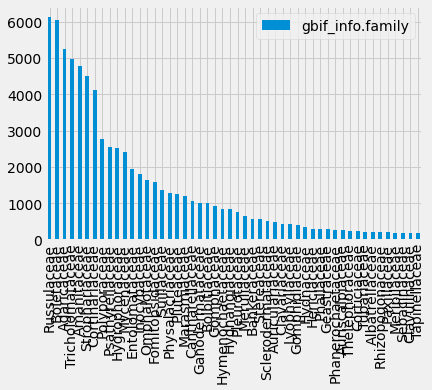

time: 787 ms (started: 2022-01-14 08:19:28 +00:00)


In [48]:
value_counts = pd.DataFrame(df_raw['gbif_info.family'].value_counts()).iloc[:50]
value_counts.plot(kind='bar')

## Define list for nested loops

In [49]:
new_res_lst = [(24 , 32),(48 , 64),(72 , 96)] # (24 , 32),(48 , 64),(72 , 96)
min_img_per_fam_lst = [6000] # 1000,2000,3000,4000
models = [RandomForestClassifier(n_jobs=-2)] # tester SVC à l'occasion

time: 2.92 ms (started: 2022-01-14 08:19:29 +00:00)


## Loops !

- on genere 1 df pour une resolution d'image donnée puis:
    - on genere un df pour un thld sur le min d'images par classes 
        - on applique un RF 
        - (on applique un SVM) 

J'ai du relancer plusieurs fois avec la resolution la plus élevée (72 , 96) car plantage RAM et pas possible pour le seuil de 1000 images/classe

In [50]:
# # /!\ clear export dir 
# dir = export_dir
# for f in os.listdir(dir):
#     os.remove(os.path.join(dir, f))

time: 2.57 ms (started: 2022-01-14 08:19:29 +00:00)


In [51]:
if loop_over_images:

  times_dataset = {}
  times_fit_model = {}
  i = 0 # counter pour dict key 
  # loop per resolution 
  for new_res in reversed(new_res_lst):
        tic1 = time.time()
        print('+'*120)
        print('The resolution is {}'.format(new_res))
        # define img size 
        pix_rows,pix_cols = new_res[0], new_res[1]
        # build df with filter min 
        # filter on number of images per class 
        global_min_fam_count = min(min_img_per_fam_lst) #comme on genere une fois le df on veut toutes les classes pour lesquelles on a le min d'images
        df_path_infos = df_raw[df_raw['family_count']>global_min_fam_count] 
        # generate data set with features for ML (image to array) 
        X, y,img_id_lst,fam_cnt_lst  = build_feat_array(df_path_infos,pix_rows,pix_cols)
        # timer to build dataset 
        time_to_build_dataset = time.time() - tic1
        # save timer 
        times_dataset[new_res] = time_to_build_dataset
        times_dataset_df = pd.DataFrame.from_dict(times_dataset, orient='index').reset_index()
        times_dataset_df = times_dataset_df.rename(columns={'index':'res', 0: 'time_to_build_img_df'})
        times_dataset_df.to_csv(export_dir +'times_dataset.csv')
        print('il faut {}min pour construire le dataset'.format(round(time_to_build_dataset /60,3)))
        print('+'*120)
        # plot & export some examples
        np.random.seed(seed=42)
        idx_lst = np.random.randint(0,len(X),6)
        image_ids, fig = plot_examples(idx_lst,pix_rows, pix_cols)
        #             display(fig)
        fig.savefig(export_dir + str(new_res) + '_example.jpeg' )
        # loop sur img/classes à partir du data set généré 
        for thld in reversed(min_img_per_fam_lst):
            # boolean index sur seuil d'images par classe
            mask = np.array(fam_cnt_lst)>thld
            X_ = X[mask] # features 
            y_ = np.array(y)[mask] #target            
            print('Seuil de {} images par classes'.format(thld))
            print([[x,y.count(x)] for x in set(y_)])
            # train ML models pour 1 seuil d'image
            for model in models:
                print('-'*120)
                tic2 = time.time()
                report = fit_and_assess(X_,y_,model,random_seed)
                # save report 
                display(report)
                csv_path = export_dir + str(model.__class__.__name__) + '_' + str(new_res) + '_' + str(thld) + \
                        'img per family'+ '_classification report.csv'
                report.to_csv(csv_path)
                # infos + timer 
                print('The model is {}: acc = {}, weighted avg = {}'.format(model.__class__.__name__,
                                                                            report.loc['accuracy','f1-score'],
                                                                            report.loc['weighted avg','f1-score']))
                time_to_fit = time.time() - tic2
                times_fit_model[i] = [new_res,thld,model,time_to_fit] 
                pd.DataFrame.from_dict(times_fit_model, orient='index',
                                        columns = ['res','min_img_per_class','model','time_to_fit']).to_csv(export_dir +'times_model.csv')
                print('il faut {}min pour construire le model'.format(round(time_to_fit/60,3)))   
                i = i +1
                print('-'*120)


   

time: 71.2 ms (started: 2022-01-14 08:19:29 +00:00)


In [52]:
if loop_over_images:
  # to check correspondane with raw files 
  for image_id in image_ids:
      print(str(summary.loc[summary['image_id'] == image_id,'file_path'].values[0]).replace('/',os.sep).replace('\\\\',os.sep) + 
            '-'*10 + '>' +
            str(summary.loc[summary['image_id'] == image_id,'gbif_info.family'].values[0]))

time: 2.34 ms (started: 2022-01-14 08:19:29 +00:00)


# Loop over report to compare performances 

## Generate summary df


In [53]:
# get last export directory 
# list_of_dir = glob.glob(export_dir)
# latest_dir = max(list_of_dir, key=os.path.getctime)

# manually define 
perf_report_dir = ML_dir  + 'RF reports/'
print('perf_report_dir  is {}'.format(perf_report_dir ))

perf_report_dir  is /content/drive/MyDrive/Projet datascientest/DOE_Resolution_images/export/RF reports/
time: 1.56 ms (started: 2022-01-14 08:19:29 +00:00)


In [54]:
# get reports
classif_reports = next(os.walk(perf_report_dir), (None, None, []))[2]  # [] if no file
classif_reports = [perf_report_dir + '/' +  report for report in classif_reports if 'classification report' in report]

time: 4.3 ms (started: 2022-01-14 08:19:29 +00:00)


In [55]:
# create summary df from classif reports 
class_numbers = []
accuracys = []
avg_f1s = []
weighted_f1 = []
res_lst = []
img_per_class = []

report_csv = classif_reports[0]
for report_csv in classif_reports:
    rep_df = pd.read_csv(report_csv, index_col = 'Unnamed: 0')
    # exttract resolution
    string = '\(\d+, \d+\)'
    res = re.findall(string, report_csv )[0]
    res_lst.append(res)
    # extract threshlod of images per class 
    img_per_class.append(int(re.findall('\d+img', report_csv )[0].replace('img','')))
    # extract class number and scores 
    class_numbers.append(len(rep_df)-3)
    accuracys.append(rep_df.loc['accuracy','f1-score'])
    avg_f1s.append(rep_df.loc['macro avg','f1-score'])
    weighted_f1.append(rep_df.loc['weighted avg','f1-score'])
# generate df
classif_summary_df = pd.DataFrame(list(zip(res_lst,img_per_class,class_numbers,accuracys,avg_f1s,weighted_f1)),
            columns = ['res','min_img_per_class','number_of_classes','accuracy','avg_f1','wgt_avg_f1'])

time: 61.5 ms (started: 2022-01-14 08:19:29 +00:00)


In [56]:
# extract times info 
times_dataset = pd.read_csv(perf_report_dir + '/' +  'times_dataset.csv',index_col = [0])
times_model = pd.read_csv(perf_report_dir + '/' +  'times_model.csv',index_col = [0])

time: 14.3 ms (started: 2022-01-14 08:19:29 +00:00)


In [57]:
# join 
perf_summary = classif_summary_df.merge(times_dataset)
perf_summary = perf_summary.merge(times_model)
perf_summary

,res,min_img_per_class,number_of_classes,accuracy,avg_f1,wgt_avg_f1,time_to_build_img_df,model,time_to_fit
0,"(72, 96)",4000,7,0.273540,0.243427,0.254361,906.791949,RandomForestClassifier(n_jobs=-2),582.250969
1,"(72, 96)",3000,7,0.269489,0.239360,0.249984,906.791949,RandomForestClassifier(n_jobs=-2),563.197651
2,"(72, 96)",2000,11,0.206387,0.147165,0.175682,906.791949,RandomForestClassifier(n_jobs=-2),849.569312
3,"(48, 64)",4000,7,0.263342,0.234685,0.244605,1055.909877,RandomForestClassifier(n_jobs=-2),266.708590
4,"(48, 64)",3000,7,0.264459,0.236638,0.246921,1055.909877,RandomForestClassifier(n_jobs=-2),263.907793
5,"(48, 64)",2000,11,0.206713,0.146654,0.176017,1055.909877,RandomForestClassifier(n_jobs=-2),393.936248
6,"(48, 64)",1000,21,0.160848,0.072838,0.120948,1055.909877,RandomForestClassifier(n_jobs=-2),644.111176
7,"(24, 32)",4000,7,0.276194,0.249238,0.259494,1480.671205,RandomForestClassifier(n_jobs=-2),159.020173
8,"(24, 32)",3000,7,0.272143,0.247316,0.256526,1480.671205,RandomForestClassifier(n_jobs=-2),153.195591
9,"(24, 32)",2000,11,0.208451,0.147990,0.178049,1480.671205,RandomForestClassifier(n_jobs=-2),223.929257


time: 43.7 ms (started: 2022-01-14 08:19:29 +00:00)


## Plot performances

In [58]:
def plot_perf(df,metric):
    fig = plt.figure(figsize=(20,5))
    sns.lineplot(x=df['number_of_classes'], y=df[metric], hue=df['res'], label='')
    plt.xlabel('Class number')
    plt.ylabel(metric)
    plt.title('{} = f(class number,resolution)'.format(metric))
    plt.close();
    return fig

time: 3.63 ms (started: 2022-01-14 08:19:29 +00:00)


--------------------------------------------------accuracy--------------------------------------------------


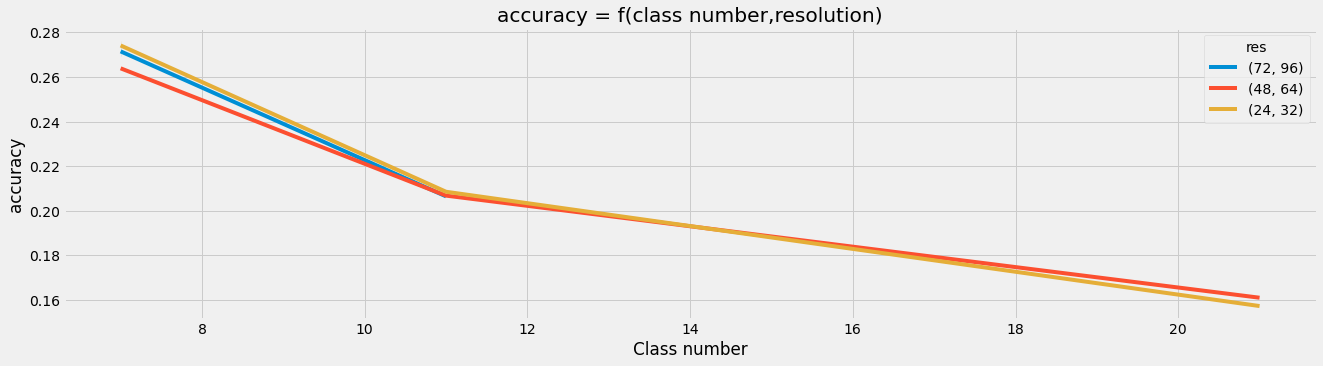

--------------------------------------------------avg_f1--------------------------------------------------


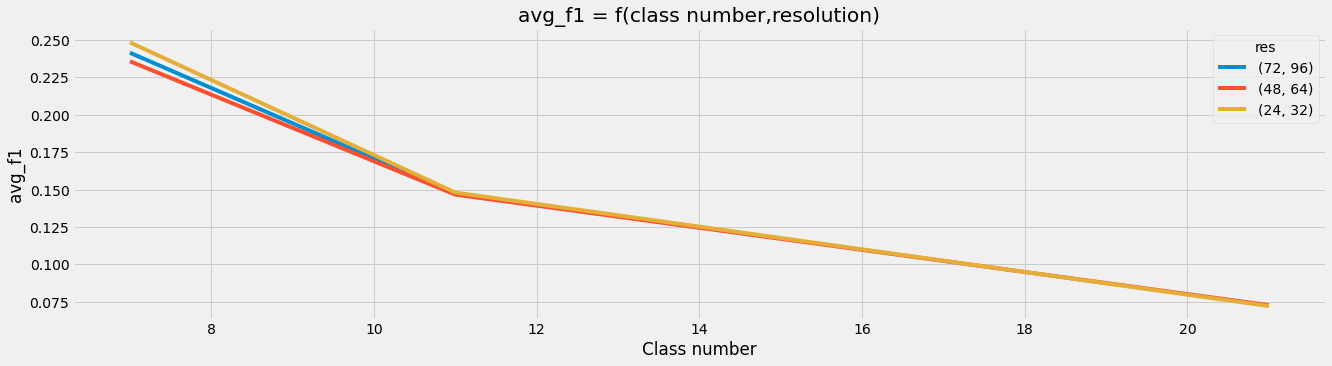

--------------------------------------------------wgt_avg_f1--------------------------------------------------


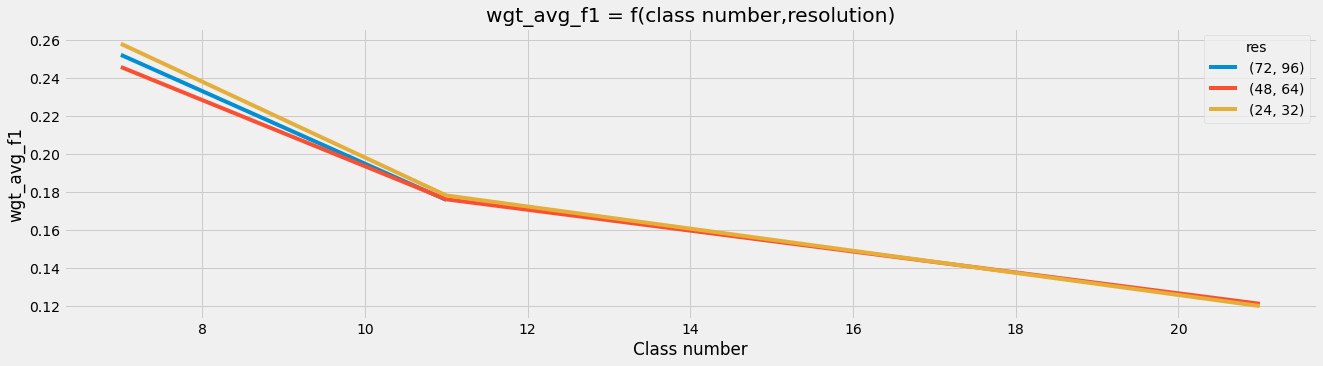

--------------------------------------------------time_to_build_img_df--------------------------------------------------


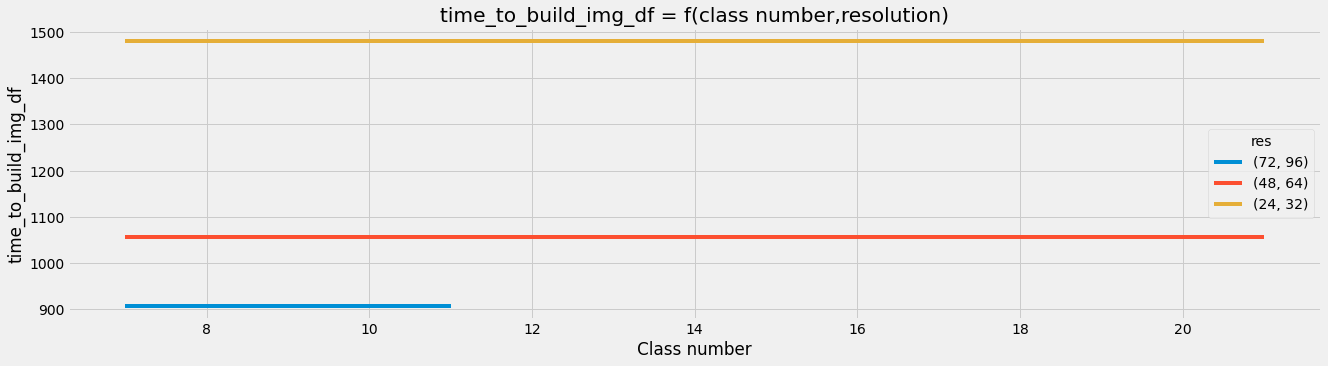

--------------------------------------------------time_to_fit--------------------------------------------------


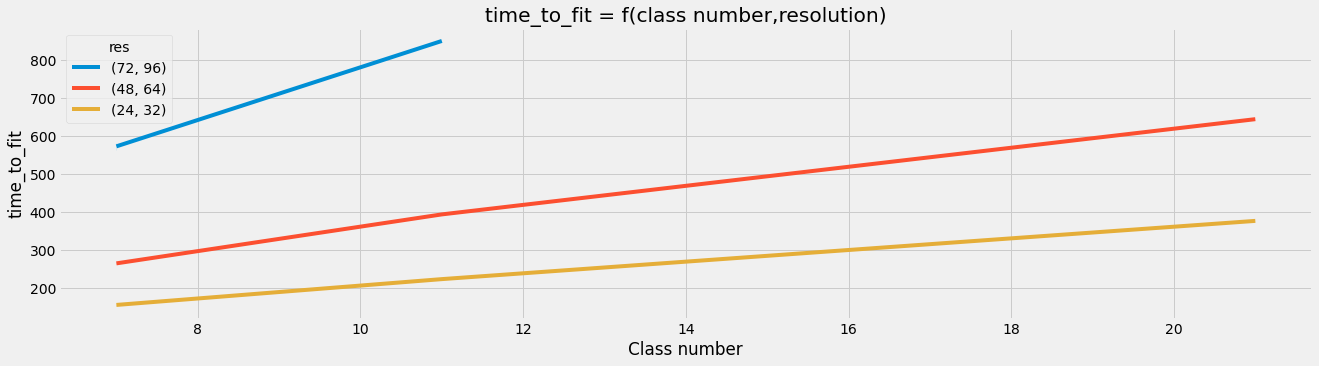

time: 2.14 s (started: 2022-01-14 08:19:29 +00:00)


In [59]:
# /!\ a modifier si plusieurs models 
for metric in ['accuracy', 'avg_f1','wgt_avg_f1', 'time_to_build_img_df','time_to_fit']:
    print('-'*50 + metric + '-'*50)
    fig = plot_perf(perf_summary,metric)
    display(fig)

##check example

/content/drive/MyDrive/Projet datascientest/DOE_Resolution_images/export/RF reports//(24, 32)_example.jpeg
/content/drive/MyDrive/Projet datascientest/DOE_Resolution_images/export/RF reports//(48, 64)_example.jpeg
/content/drive/MyDrive/Projet datascientest/DOE_Resolution_images/export/RF reports//(72, 96)_example.jpeg


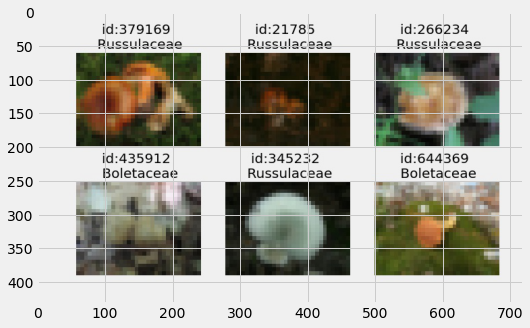

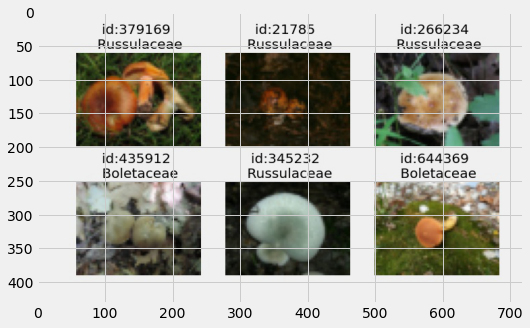

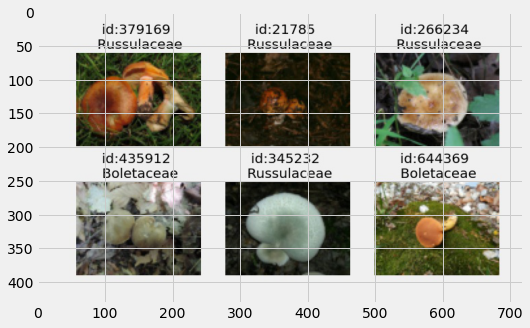

time: 1.34 s (started: 2022-01-14 08:19:31 +00:00)


In [60]:
 # get reports
filename_lst = next(os.walk(perf_report_dir), (None, None, []))[2]  # [] if no file
filename_lst  = [perf_report_dir + '/' +  filename for filename in filename_lst if 'example' in filename]
filename_lst.sort()
for img_path in filename_lst:
  img = io.imread(img_path)
  print(img_path)
  plt.figure( figsize=(10,5))
  plt.imshow(img)
  